In [466]:
# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx
import seaborn as sns
from IPython.display import HTML
from matplotlib import animation

# Setup

## Parameters

In [536]:
plotIter=1000
nnodes=100
p_link=.1
leak=.25 #
leaktype=1 #1 = leak a percentage, or 2 = leak a constant rate
lrate_wmat=.1
lrate_targ=.01
targ_min=1
sens_offset=20
movement_amp=2
input_amp=5

## Plotting

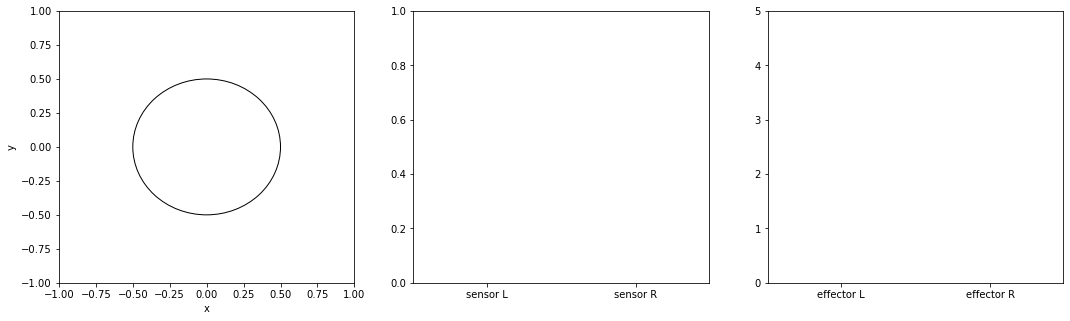

In [537]:
# create a figure and axes
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

# set up the subplots as needed
ax1.set_xlim(( -1, 1))            
ax1.set_ylim((-1, 1))
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_ylim((0, 1))
ax3.set_ylim((0, 5))

circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(circle1)

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
pt1, = ax1.plot([], [], 'g.', ms=30)
sL, = ax1.plot([],[], 'r.', ms =20)
sR, = ax1.plot([],[], 'b.', ms =20)
bar1_plt2, bar2_plt2 = ax2.bar(['sensor L', 'sensor R'],[0,0])
bar1_plt3, bar2_plt3 = ax3.bar(['effector L', 'effector R'],[0,0])

## Set up sensor nodes and input connections

In [538]:
sensory_nodes=[]
input_wmat=np.zeros((2,nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]
        if input_wmat[row,col] > 0:
            sensory_nodes.append(col)
        
#select two random nodes to be output nodes
output_nodes = random.sample(range(1, nnodes), 2)
while (output_nodes[0] in sensory_nodes) or (output_nodes[1] in sensory_nodes):
    output_nodes = random.sample(range(1, nnodes), 2)

np.unique(sensory_nodes)
#output_nodes

array([ 3, 10, 18, 25, 37, 38, 40, 41, 54, 55, 62, 63, 64, 65, 66, 71, 74,
       85, 88, 95, 96])

In [539]:
output_nodes

[23, 73]

## Set up internal weight matrix

In [540]:
link_mat = np.zeros((nnodes,nnodes))
for row in range(link_mat.shape[0]):
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
# link_mat[:,:]=1
# np.fill_diagonal(link_mat,0)
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] = np.random.normal(0,1)
            
start_wmat=wmat.copy()

## Functions

In [541]:
def get_plot_vals(degree, heading):
    x = np.cos(np.radians(degree))
    y = np.sin(np.radians(degree))
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    sLx = .5*np.cos(np.radians(sLdeg)) 
    sLy = .5*np.sin(np.radians(sLdeg)) 
    sLpos = np.array([sLx,sLy])
    
    sRx = .5*np.cos(np.radians(sRdeg)) 
    sRy = .5*np.sin(np.radians(sRdeg))
    sRpos = np.array([sRx, sRy])
    
    return x, y, sLx, sLy, sRx, sRy

def move_stim(degree):
    degree += 1
    if degree == 360:
        degree = 0
    if degree == -1:
        degree = 359

    return degree

def rotate_agent(output_acts, output_spikes, heading):
    diff = (output_acts[0] - output_acts[1])*movement_amp
    #diff = (output_spikes[0] - output_spikes[1])*movement_amp
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
    
    return heading

def get_input_acts(heading, degree):
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
        
    dL = np.abs(degree - sLdeg)
    if dL > 180:
        dL = 360 - dL
        
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    dR = np.abs(degree - sRdeg)
    if dR > 180:
        dR = 360 - dR
    
    sL_act = 1 - dL/180
    sR_act = 1 - dR/180
    
    return [sL_act, sR_act], [dL, dR]

def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets):
    if leaktype == 1:
        acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    else:
        acts = acts-leak + np.dot(input, input_wmat) + np.dot(spikes, wmat)
        
    acts[acts<0]=0
    
    thresholds = targets*2
    #CAN I MAKE NEURONS SPIKE MORE THAN ONCE IN THE TIME FRAME, eg spikes = np.floor(acts/thresholds) 
    #spikes = np.floor(acts/thresholds)
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1]
    #acts = acts - thresholds*spikes
       
    errors=acts-targets
    
    output_acts = acts[output_nodes]
    output_spikes = spikes[output_nodes]
    
    return acts, spikes, errors, output_acts, output_spikes

def learning(learn_on,link_mat,prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            d_wmat = np.zeros((nnodes,nnodes))
            d_wmat[:,:]=errors*lrate_wmat
            d_wmat[link_mat==0]=0
            d_wmat[prev_inactive,:]=0
            d_wmat=(d_wmat/active_neighbors)
            d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat
            
        targets=targets+(errors*lrate_targ) # could multiply by acts, so that this value naturally can't go below 0? but that will also amplify the change when acts are very high
        targets[targets<targ_min]=targ_min
        
    return wmat, targets



# Run the model

In [542]:
spikes=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(2)
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]

i=1
degree = 0
heading = 0
learn_on=1
def drawframe(n):
    global degree, heading, acts, input_acts, output_acts, output_spikes,leak, spikes, prev_spikes, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs,MeanSpikes
    
    input, dists = get_input_acts(heading, degree)
        
    prev_spikes = spikes.copy()
    
    acts, spikes, errors, output_acts, output_spikes = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
        
    wmat, targets = learning(learn_on,link_mat,prev_spikes, errors, wmat,targets)
    #acts=acts-((targets*2)*spikes)
    
    x, y, sLx, sLy, sRx, sRy = get_plot_vals(degree, heading)
    
    degree = move_stim(degree)
    heading = rotate_agent(output_acts, output_spikes,heading)
    
    pt1.set_data(x,y)
    sL.set_data(sLx,sLy)
    sR.set_data(sRx,sRy)
    bar1_plt2.set_height(input[0])
    bar2_plt2.set_height(input[1])
    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    
    txt_title.set_text('Frame = {0:4d}'.format(n))
    
    if (n % 100 !=0):
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        #print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
    else:
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        
        MeanAbsEr = np.mean(MeanAbsErs)
        MeanAct = np.mean(MeanActs)
        print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
        MeanAbsErs=[]
        MeanActs=[]
    
    return (pt1,sL,sR)
        


In [543]:
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=plotIter, interval=20, blit=False)

In [544]:
HTML(anim.to_html5_video())

iteration:  0  ; MeanAbsEr:  1.2266666666666666  ; MeanAct:  0.6466666666666666
iteration:  0  ; MeanAbsEr:  1.437308548021603  ; MeanAct:  1.284509403344732


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


iteration:  100  ; MeanAbsEr:  0.722966425012531  ; MeanAct:  1.0673981679688644
iteration:  200  ; MeanAbsEr:  0.585714450586425  ; MeanAct:  1.0853579248954697
iteration:  300  ; MeanAbsEr:  0.5266567751324973  ; MeanAct:  1.0933236748812094
iteration:  400  ; MeanAbsEr:  0.5479047933051995  ; MeanAct:  0.8250780607640238
iteration:  500  ; MeanAbsEr:  0.5393892056601954  ; MeanAct:  1.224982833670081
iteration:  600  ; MeanAbsEr:  0.3539323233376528  ; MeanAct:  1.1870398530495436
iteration:  700  ; MeanAbsEr:  0.1783318564371889  ; MeanAct:  1.1002897875502322
iteration:  800  ; MeanAbsEr:  0.15363748581870978  ; MeanAct:  1.142391946693316
iteration:  900  ; MeanAbsEr:  0.11786230578465919  ; MeanAct:  1.2454236339396163


In [ ]:
# hist of wmat
n, bins, patches = plt.hist(x=np.matrix.flatten(wmat), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Weights at End')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# hist of wmat
n, bins, patches = plt.hist(x=targets, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Targets at End')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)